In [ ]:
from google.colab import userdata


# Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import math
import warnings
import random
warnings.filterwarnings("ignore")

random.seed(1000)


#Exploratory Data Analysis

In [ ]:
# LOAD DATA
df = pd.read_excel("champions_group_data.xlsx")
print("Shape:", df.shape)   # .shape returns the (rows, columns) of the DataFrame
df.head()   # shows first 5 rows of df

Shape: (8559, 72)


,DUNS Number,Company Sites,Website,Address Line 1,City,State,State Or Province Abbreviation,Postal Code,Country,Phone Number,...,ISIC Rev 4 Code,ISIC Rev 4 Description,IT Budget,IT spend,No. of PC,No. of Desktops,No. of Laptops,No. of Routers,No. of Servers,No. of Storage Devices
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",NaN,"No.2777 Taidong Road, Panyang Industrial Park,...",Suzhou,Jiangsu,JS,215000.0,CHINA,NaN,...,4662.0,Wholesale of metals and metal ores,0,0,1 to 10,1 to 10,1 to 10,1 to 10,NaN,NaN
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",NaN,"No.306, Building 8, Shuangyushudongli Jia, Hai...",Beijing,Beijing,BJ,100086.0,CHINA,1.082129e+09,...,NaN,NaN,5601,3472,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10
2,728834216,Keshan Shengren Potato Industry Processing Co....,NaN,"South of Siduan Road, Xi Street, Keshan Town, ...",Qiqihar,Heilongjiang,HL,161000.0,CHINA,NaN,...,NaN,NaN,86905,53881,11 to 50,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,NaN,"Songaoliang Village, Liaoyang Town, Zuoquan Co...",Jinzhong,Shanxi,SX,30600.0,CHINA,NaN,...,NaN,NaN,11630,7210,NaN,NaN,NaN,NaN,NaN,NaN
4,728889244,Zuoquan County Tianxin Real Estate Development...,NaN,"No.14, Chengyadao Alley, Zuoquan County ...",Jinzhong,Shanxi,SX,30600.0,CHINA,3.548653e+09,...,NaN,NaN,94564,58629,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10,1 to 10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8559 entries, 0 to 8558
Data columns (total 72 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DUNS Number                            8559 non-null   int64         
 1   Company Sites                          8559 non-null   object        
 2   Website                                625 non-null    object        
 3   Address Line 1                         8216 non-null   object        
 4   City                                   8045 non-null   object        
 5   State                                  8044 non-null   object        
 6   State Or Province Abbreviation         7824 non-null   object        
 7   Postal Code                            8062 non-null   float64       
 8   Country                                8559 non-null   object        
 9   Phone Number                           1674 non-null   float64 

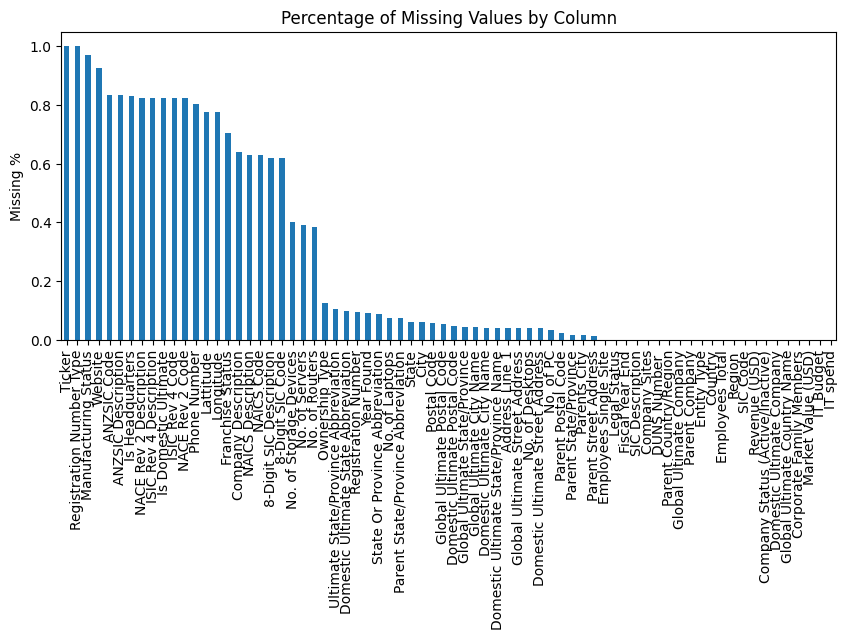

In [ ]:
# DATA ORIENTATION
df.info()   # gives structural summary of df
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical/Text columns:", cat_cols)

# MISSING DATA ANALYSIS
missing_pct = df.isnull().mean().sort_values(ascending=False) # sorted columns by percentage of missing values
missing_pct[missing_pct > 0]

plt.figure(figsize=(10,4))    # creates new figure to display plot
missing_pct[missing_pct >= 0].plot(kind="bar")
plt.title("Percentage of Missing Values by Column")
plt.ylabel("Missing %")
plt.grid(False)
plt.show()

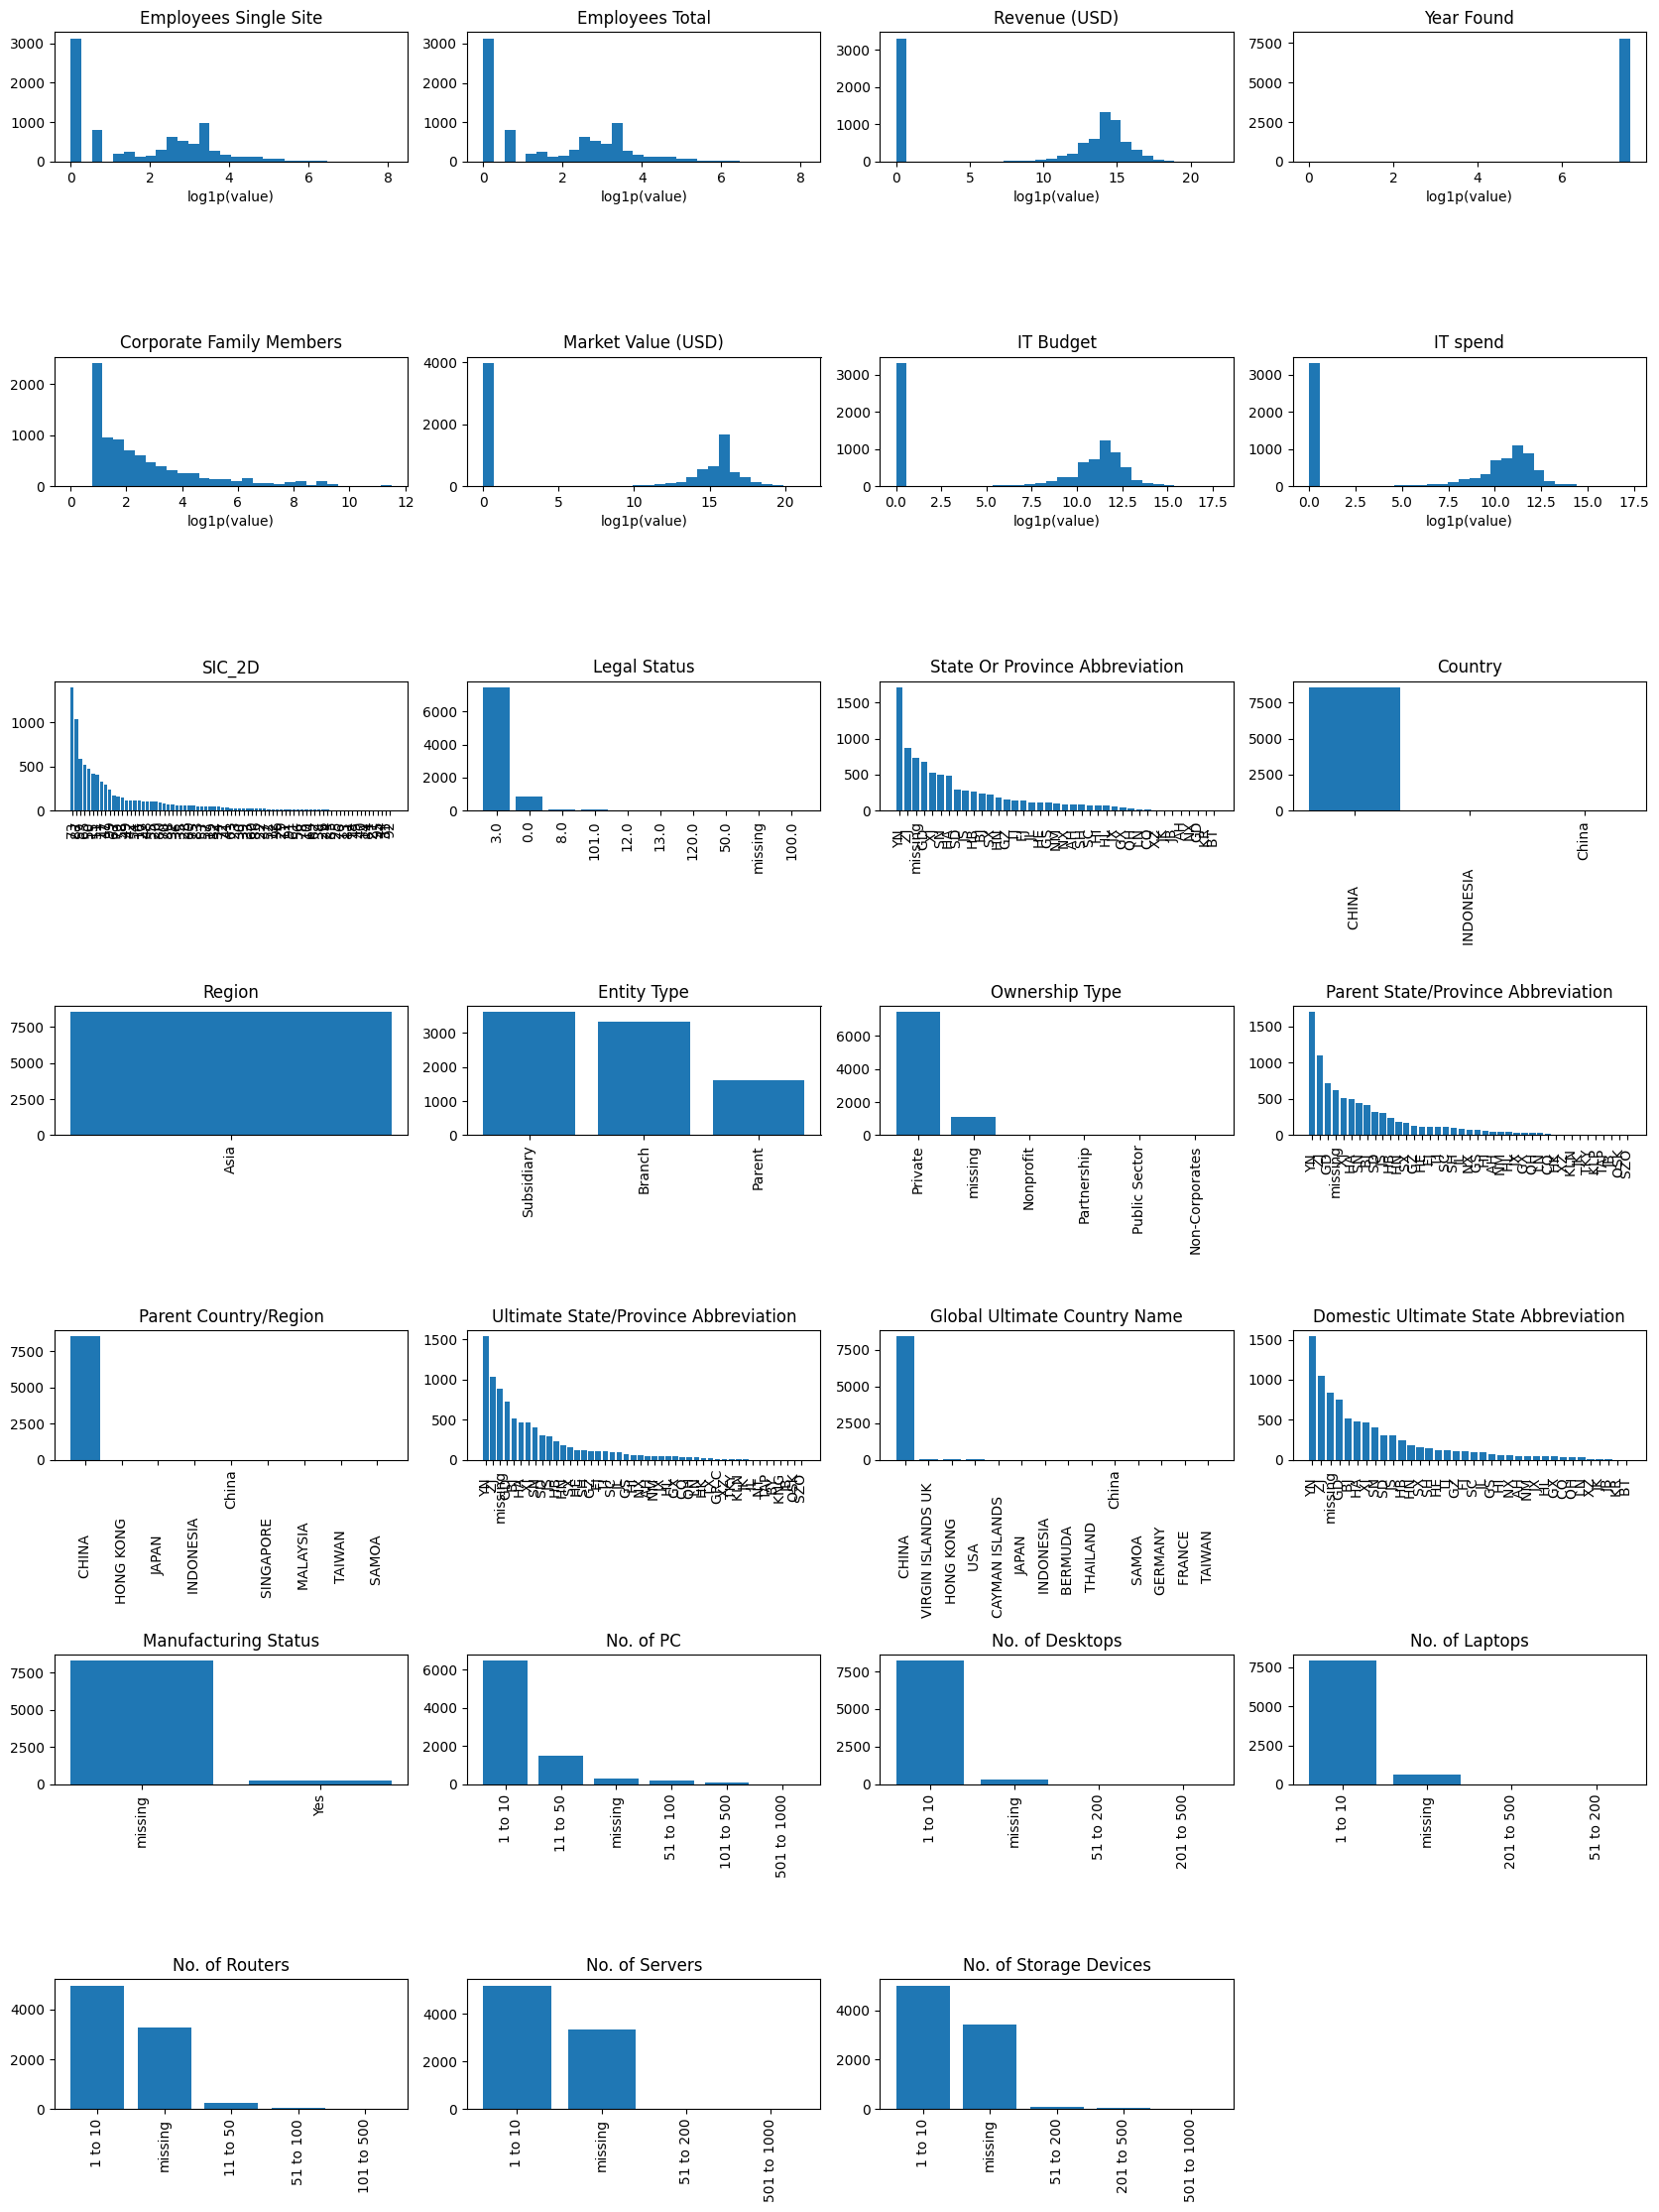

In [ ]:
## Simple data manipulation for visualisation

# 2-Digit SIC
df["SIC_2D"] = (
    df["SIC Code"]
    .astype(str)
    .str[:2]
    .fillna("missing")
)

# Coerce numeric
def _coerce_numeric(series: pd.Series) -> pd.Series:
    s = series.copy()
    if s.dtype == "O":
        s = s.astype(str).str.strip()
        s = s.replace({
            "": np.nan,
            "nan": np.nan,
            "None": np.nan,
            "NA": np.nan,
            "N/A": np.nan
        })
        s = s.str.replace(",", "", regex=False)
        s = s.str.replace("$", "", regex=False).str.replace("USD", "", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

# Make bins
def _make_bins_for_bar(numeric_s: pd.Series, max_bins: int = 10) -> pd.Categorical:
    s = numeric_s.dropna()
    if s.empty:
        return pd.Categorical(["missing"] * len(numeric_s))

    uniq = s.nunique(dropna=True)
    if uniq <= 12:
        binned = numeric_s.map(
            lambda x: "missing"
            if pd.isna(x)
            else str(int(x)) if float(x).is_integer() else str(x)
        )
        return pd.Categorical(binned)

    q = min(max_bins, max(4, int(np.sqrt(len(s)))))
    try:
        b = pd.qcut(numeric_s, q=q, duplicates="drop")
    except Exception:
        b = pd.cut(numeric_s, bins=q)

    b = b.astype("object")
    b[pd.isna(b)] = "missing"
    return pd.Categorical(b)

## Creating basic graphs to visualize given data
NUM_COLS = [
    "Employees Single Site",
    "Employees Total",
    "Revenue (USD)",
    "Year Found",
    "Corporate Family Members",
    "Market Value (USD)",
    "IT Budget",
    "IT spend",
]

CAT_COLS = [
    "SIC_2D", # force categorical
    "Legal Status",  # force categorical
    "State Or Province Abbreviation",
    "Country",
    "Region",
    "Entity Type",
    "Ownership Type",
    "Parent State/Province Abbreviation",
    "Parent Country/Region",
    "Ultimate State/Province Abbreviation",
    "Global Ultimate Country Name",
    "Domestic Ultimate State Abbreviation",
    "Manufacturing Status",
    "No. of PC",
    "No. of Desktops",
    "No. of Laptops",
    "No. of Routers",
    "No. of Servers",
    "No. of Storage Devices",
]

def plot_simple_eda(df, num_cols, cat_cols, graphs_per_row=4, bins=30, log_numeric=True):
    cols = [(c, "num") for c in num_cols if c in df.columns] + \
           [(c, "cat") for c in cat_cols if c in df.columns]

    n = len(cols)
    nrows = math.ceil(n / graphs_per_row)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=graphs_per_row,
        figsize=(4.2 * graphs_per_row, 3.2 * nrows)
    )
    axes = axes.flatten()

    for i, (col, kind) in enumerate(cols):
        ax = axes[i]

        if kind == "num":
            s = df[col].dropna()

            if s.empty:
                ax.set_title(f"{col} (all NaN)")
                ax.axis("off")
                continue

            if log_numeric and (s > 0).any():
                ax.hist(np.log1p(s), bins=bins)
                ax.set_xlabel("log1p(value)")
                ax.set_title(col)
            else:
                ax.hist(s, bins=bins)
                ax.set_title(col)

        else:
            vc = df[col].fillna("missing").value_counts()

            ax.bar(vc.index.astype(str), vc.values)
            ax.set_title(col)
            ax.tick_params(axis="x", labelrotation=90)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# PLOT
plot_simple_eda(df, NUM_COLS, CAT_COLS)

# Histograms for numerical columns, bar charts for categorical columns



In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# =========================
# 0) Setup
#=========================
CURRENT_YEAR = pd.Timestamp.today().year

LEGAL_SUFFIX_RE = re.compile(r"\b(ltd|limited|pte|plc|inc|corp|co|company|llc)\b", re.I)
PUNCT_RE = re.compile(r"[^a-z0-9\s]+")
RESTRICTED_RE = re.compile(r"restricted\s*data\s*-\s*order\s*investigation", re.I)

# =========================
# 1) Cleaning utilities
# =========================
def safe_numeric(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.mask(x < 0, np.nan)

def zero_to_nan(s: pd.Series) -> pd.Series:
    x = safe_numeric(s)
    return x.mask(x <= 0, np.nan)

def normalize_name(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.lower().str.strip()
    s = s.str.replace(LEGAL_SUFFIX_RE, "", regex=True)
    s = s.str.replace(PUNCT_RE, " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s.replace("", np.nan)

def restricted_flag(s: pd.Series) -> pd.Series:
    # strip trailing spaces like your examples show
    ss = s.fillna("").astype(str).str.strip()
    return ss.str.contains(RESTRICTED_RE, na=False)

def bucket_midpoint(val) -> float:
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    if s in {"unknown", "na", "n/a", "none", ""}:
        return np.nan
    m = re.match(r"^\s*(\d+)\s*(to|\-)\s*(\d+)\s*$", s)
    if m:
        a, b = int(m.group(1)), int(m.group(3))
        return (a + b) / 2
    m = re.match(r"^\s*(\d+)\s*\+\s*$", s)
    if m:
        a = int(m.group(1))
        return float(a * 1.25)
    return np.nan

def onehot_top_k(s: pd.Series, k=10, other_label="Other", missing_label="Unknown") -> pd.Series:
    s = s.fillna(missing_label).astype(str)
    top = s.value_counts().head(k).index
    return s.where(s.isin(top), other_label)

# =========================
# 2) CLEANING (no feature engineering here)
# =========================
df_clean = df.copy()

# --- Numeric coercion ---
num_cols = [
    "Employees Single Site", "Employees Total",
    "Revenue (USD)", "Market Value (USD)",
    "Corporate Family Members", "IT Budget", "IT spend",
    "Year Found"
]
for c in num_cols:
    if c in df_clean.columns:
        df_clean[c] = safe_numeric(df_clean[c])

# --- Year Found fixes ---
if "Year Found" in df_clean.columns:
    df_clean["Year Found"] = df_clean["Year Found"].round()
    df_clean["Year Found"] = df_clean["Year Found"].mask(df_clean["Year Found"] <= 0, np.nan)
    df_clean["Year Found"] = df_clean["Year Found"].mask(
        (df_clean["Year Found"] < 1800) | (df_clean["Year Found"] > CURRENT_YEAR),
        np.nan
    )

# --- Treat "0 means unknown" as missing for these ---
for c in ["Revenue (USD)", "Market Value (USD)", "IT Budget", "IT spend"]:
    if c in df_clean.columns:
        df_clean[c] = zero_to_nan(df_clean[c])

# Employees: <=0 is unknown
for c in ["Employees Total", "Employees Single Site"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].mask(df_clean[c] <= 0, np.nan)

# Missing flags (keep them for modeling + interpretation)
for c in ["Revenue (USD)", "Market Value (USD)", "IT Budget", "IT spend", "Employees Total"]:
    if c in df_clean.columns:
        df_clean[f"{c} Missing"] = df_clean[c].isna().astype(int)

# Optional: compact state bucket (categorical)
if "State Or Province Abbreviation" in df_clean.columns:
    df_clean["StateTop10"] = onehot_top_k(df_clean["State Or Province Abbreviation"], k=10)

# =========================
# 3) FEATURE ENGINEERING
# =========================

# --- Age ---
# Calculate the median 'Year Found'
median_year_found = df_clean['Year Found'].median()

# Impute missing 'Year Found' values with the median
df_clean['Year Found'] = df_clean['Year Found'].fillna(median_year_found)

# Recalculate 'CompanyAge' after imputation
CURRENT_YEAR = pd.Timestamp.today().year # Ensure CURRENT_YEAR is up-to-date
df_clean['CompanyAge'] = (CURRENT_YEAR - df_clean['Year Found']).where(df_clean['Year Found'].notna(), np.nan)

# --- Device bucket midpoints + disclosure count ---
device_cols = ["No. of PC", "No. of Desktops", "No. of Laptops", "No. of Routers", "No. of Servers", "No. of Storage Devices"]
for c in device_cols:
    if c in df_clean.columns:
        df_clean[f"{c}_mid"] = df_clean[c].apply(bucket_midpoint)

mid_cols = [f"{c}_mid" for c in device_cols if c in df_clean.columns]
df_clean["DeviceInfoCount"] = df_clean[mid_cols].notna().sum(axis=1) if mid_cols else 0

# --- Corporate hierarchy normalization + flags ---
df_clean["CompanyName_norm"] = normalize_name(df_clean["Company Sites"])
df_clean["Parent_norm"]      = normalize_name(df_clean["Parent Company"])
df_clean["Global_norm"]      = normalize_name(df_clean["Global Ultimate Company"])
df_clean["Domestic_norm"]    = normalize_name(df_clean["Domestic Ultimate Company"])

# Restricted flags (fixed)
if "Parent Company" in df_clean.columns:
    df_clean["ParentRestricted"] = restricted_flag(df_clean["Parent Company"])
else:
    df_clean["ParentRestricted"] = False

if "Global Ultimate Company" in df_clean.columns:
    df_clean["GlobalRestricted"] = restricted_flag(df_clean["Global Ultimate Company"])
else:
    df_clean["GlobalRestricted"] = False

if "Domestic Ultimate Company" in df_clean.columns:
    df_clean["DomesticRestricted"] = restricted_flag(df_clean["Domestic Ultimate Company"])
else:
    df_clean["DomesticRestricted"] = False

df_clean["OwnershipOpacityScore"] = (
    df_clean[["ParentRestricted", "GlobalRestricted", "DomesticRestricted"]]
    .astype(int)
    .sum(axis=1)
)

# Own parent/ultimate flags
df_clean["IsOwnParent"] = (
    df_clean["CompanyName_norm"].notna() & df_clean["Parent_norm"].notna() &
    (df_clean["CompanyName_norm"] == df_clean["Parent_norm"])
).astype(int)

df_clean["IsOwnGlobalUltimate"] = (
    df_clean["CompanyName_norm"].notna() & df_clean["Global_norm"].notna() &
    (df_clean["CompanyName_norm"] == df_clean["Global_norm"])
).astype(int)

df_clean["IsOwnDomesticUltimate"] = (
    df_clean["CompanyName_norm"].notna() & df_clean["Domestic_norm"].notna() &
    (df_clean["CompanyName_norm"] == df_clean["Domestic_norm"])
).astype(int)

# Cross-border flags (only if columns exist)
if "Country" in df_clean.columns and "Parent Country/Region" in df_clean.columns:
    df_clean["ParentCrossBorder"] = (df_clean["Country"] != df_clean["Parent Country/Region"]).astype(int)
else:
    df_clean["ParentCrossBorder"] = np.nan

if "Country" in df_clean.columns and "Global Ultimate Country Name" in df_clean.columns:
    df_clean["GlobalCrossBorder"] = (df_clean["Country"] != df_clean["Global Ultimate Country Name"]).astype(int)
else:
    df_clean["GlobalCrossBorder"] = np.nan

# Ratios (safe)
emp = df_clean.get("Employees Total", pd.Series([np.nan]*len(df_clean)))
df_clean["ITSpendPerEmployee"] = np.where(emp.notna() & (emp > 0), df_clean.get("IT spend", np.nan) / emp, np.nan)
df_clean["ServersPer100Emp"]   = np.where(emp.notna() & (emp > 0), 100.0 * df_clean.get("No. of Servers_mid", np.nan) / emp, np.nan)

# log transform

BASE_RAW_NUMS = [
    "Revenue (USD)", "Market Value (USD)",
    "Employees Total", "Employees Single Site",
    "IT Budget", "IT spend",
    "ITSpendPerEmployee", "ServersPer100Emp",
    "Corporate Family Members",
    "CompanyAge" # Added CompanyAge here to ensure _raw and _transformed columns are created
]
for c in BASE_RAW_NUMS:
    if c in df_clean.columns:
        df_clean[f"{c}_raw"] = df_clean[c].astype(float)

TRANSFORM_COLS_RAW = [
    "Revenue (USD)_raw", "Market Value (USD)_raw",
    "Employees Total_raw", "Employees Single Site_raw",
    "IT Budget_raw", "IT spend_raw",
    "ITSpendPerEmployee_raw", "ServersPer100Emp_raw",
    "Corporate Family Members_raw",
    "CompanyAge_raw",
    "DeviceInfoCount_raw"
]

for raw_col in [c for c in TRANSFORM_COLS_RAW if c in df_clean.columns]:
    x = df_clean[raw_col].copy()

    # guard: treat negatives as missing
    x = x.mask(x < 0, np.nan)

    # winsorize on raw scale FIRST (your intended)
    lo = x.quantile(0.01)
    hi = x.quantile(0.99)
    x = x.clip(lower=lo, upper=hi)

    # log1p (safe for 0/positive); NaN stays NaN
    x = np.log1p(x)

    # store
    df_clean[raw_col.replace("_raw", "_transformed")] = x

scale_cols_present = [c for c in df_clean.columns if c.endswith("_transformed")]
scaler = StandardScaler()
df_clean[scale_cols_present] = scaler.fit_transform(df_clean[scale_cols_present])

# =========================
# 4) SPLIT INTO LENSES (small concrete feature sets)
# =========================
ID_COLS = ["DUNS Number ", "Company Sites"]

df_firm = df_clean[[c for c in [
    "SIC_2D", "Ownership Type", "Entity Type", "Legal Status",
    "Employees Total_transformed", "Employees Single Site_transformed",
    "Revenue (USD)_transformed", "Market Value (USD)_transformed",
    "CompanyAge_transformed", "Corporate Family Members_transformed",
    "IT Budget_transformed", "IT spend_transformed",
    "Revenue (USD) Missing", "Market Value (USD) Missing",
    "IT Budget Missing", "IT spend Missing", "Employees Total Missing",
] if c in df_clean.columns]].copy()

df_tech = df_clean[[c for c in [
    "SIC_2D", "Ownership Type",
    "Employees Total_transformed",
    "IT Budget_transformed", "IT spend_transformed",
    "ITSpendPerEmployee_transformed",
    "No. of Desktops_mid_raw", "No. of Laptops_mid_raw", "No. of Routers_mid_raw",
    "No. of Servers_mid_raw", "No. of Storage Devices_mid_raw",
    "ServersPer100Emp_transformed", "DeviceInfoCount_transformed",
    "IT Budget Missing", "IT spend Missing", "Employees Total Missing",
] if c in df_clean.columns]].copy()

df_comp = df_clean[[c for c in [
    "SIC_2D", "Ownership Type", "Entity Type", "Legal Status",
    "Corporate Family Members_transformed",
    "IsOwnParent", "IsOwnGlobalUltimate", "IsOwnDomesticUltimate",
    "ParentCrossBorder", "GlobalCrossBorder",
    "ParentRestricted", "GlobalRestricted", "DomesticRestricted",
    "OwnershipOpacityScore_raw",  # score is already small integer; keep raw
] if c in df_clean.columns]].copy()


print("Firm lens:", df_firm.shape)
print("Tech lens:", df_tech.shape)
print("Complexity lens:", df_comp.shape)

Firm lens: (8559, 17)
Tech lens: (8559, 10)
Complexity lens: (8559, 13)


In [ ]:
# One Hot Encoding for relevant:

# ---- Firmographic lens ----
X_firm = pd.get_dummies(
    df_firm,
    columns=[
        "Entity Type",
        "Ownership Type",
        "Legal Status",
        "SIC_2D",
    ],
    dummy_na=True,
    drop_first=False
)

# ---- Tech lens ----
X_tech = pd.get_dummies(
    df_tech,
    columns=[
        "Ownership Type",
        "SIC_2D",
    ],
    dummy_na=True,
    drop_first=False
)

# ---- Complexity lens ----
X_comp = pd.get_dummies(
    df_comp,
    columns=[
        "Entity Type",
        "Ownership Type",
        "Legal Status",
        "SIC_2D",
    ],
    dummy_na=True,
    drop_first=False
)


print("Firm (encoded):", X_firm.shape)
print("Tech (encoded):", X_tech.shape)
print("Complexity (encoded):", X_comp.shape)


Firm (encoded): (8559, 111)
Tech (encoded): (8559, 92)
Complexity (encoded): (8559, 107)


In [ ]:
# Check all are numeric columns

def check_dtypes(X, name):
    bad = X.select_dtypes(exclude=["number"]).columns.tolist()
    print(f"{name}: non-numeric columns →", bad)

check_dtypes(X_firm, "Firm")
check_dtypes(X_tech, "Tech")
check_dtypes(X_comp, "Complexity")

X_firm.dtypes.value_counts()
X_tech.dtypes.value_counts()
X_comp.dtypes.value_counts()


Firm: non-numeric columns → ['Entity Type_Branch', 'Entity Type_Parent', 'Entity Type_Subsidiary', 'Entity Type_nan', 'Ownership Type_Non-Corporates', 'Ownership Type_Nonprofit', 'Ownership Type_Partnership', 'Ownership Type_Private', 'Ownership Type_Public Sector', 'Ownership Type_nan', 'Legal Status_0.0', 'Legal Status_3.0', 'Legal Status_8.0', 'Legal Status_12.0', 'Legal Status_13.0', 'Legal Status_50.0', 'Legal Status_100.0', 'Legal Status_101.0', 'Legal Status_120.0', 'Legal Status_nan', 'SIC_2D_10', 'SIC_2D_11', 'SIC_2D_12', 'SIC_2D_13', 'SIC_2D_14', 'SIC_2D_15', 'SIC_2D_16', 'SIC_2D_17', 'SIC_2D_18', 'SIC_2D_19', 'SIC_2D_20', 'SIC_2D_21', 'SIC_2D_22', 'SIC_2D_23', 'SIC_2D_24', 'SIC_2D_25', 'SIC_2D_26', 'SIC_2D_27', 'SIC_2D_28', 'SIC_2D_29', 'SIC_2D_30', 'SIC_2D_31', 'SIC_2D_32', 'SIC_2D_33', 'SIC_2D_34', 'SIC_2D_35', 'SIC_2D_36', 'SIC_2D_37', 'SIC_2D_38', 'SIC_2D_39', 'SIC_2D_40', 'SIC_2D_41', 'SIC_2D_42', 'SIC_2D_44', 'SIC_2D_45', 'SIC_2D_47', 'SIC_2D_48', 'SIC_2D_49', 'SIC_2D_

,count
bool,101
int64,5
float64,1


In [ ]:
# Preparing for cluster

# NaN --> 0 as missingness has already been explicitely encoded
X_firm = X_firm.fillna(0)
X_tech = X_tech.fillna(0)
X_comp = X_comp.fillna(0)

# Convert boolean columns to int for numeric consistency
X_firm = X_firm.astype(int, errors='ignore')
X_tech = X_tech.astype(int, errors='ignore')
X_comp = X_comp.astype(int, errors='ignore')

# Sanity check
# 1. No NaN
assert X_firm.isna().sum().sum() == 0
assert X_tech.isna().sum().sum() == 0
assert X_comp.isna().sum().sum() == 0

# 2. All numeric
assert X_firm.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()

# PCA



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

HAS_UMAP = False
HAS_HDBSCAN = False

try:
    import umap
    HAS_UMAP = True
except Exception:
    pass

try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    pass

print("UMAP available:", HAS_UMAP)
print("HDBSCAN available:", HAS_HDBSCAN)

UMAP available: True
HDBSCAN available: True


In [ ]:
X_firm = X_firm.astype(float)
X_tech = X_tech.astype(float)
X_comp = X_comp.astype(float)

def pca_cluster_diagnostics(X, lens_name, max_pcs=50, max_k=10):
    print(f"\n================ {lens_name} =================")
    print(f"Shape: {X.shape}")

    # ---------- PCA ----------
    n_pcs = min(max_pcs, X.shape[1])
    pca = PCA(n_components=n_pcs, random_state=42)
    X_pca = pca.fit_transform(X)

    # Explained variance
    pca_var = pd.DataFrame({
        "PC": np.arange(1, n_pcs + 1),
        "ExplainedVariance": pca.explained_variance_ratio_,
        "CumulativeVariance": np.cumsum(pca.explained_variance_ratio_)
    })

    display(pca_var.head(15))

    # Scree plot
    plt.figure(figsize=(7, 4))
    plt.plot(pca_var["PC"], pca_var["CumulativeVariance"], marker="o")
    plt.axhline(0.6, linestyle="--", color="red")
    plt.axhline(0.8, linestyle="--", color="green")
    plt.xlabel("Number of PCs")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"{lens_name} – PCA Cumulative Variance")
    plt.show()

    # ---------- PCA Loadings ----------
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns,
        columns=[f"PC{i}" for i in range(1, n_pcs + 1)]
    )

    for pc in ["PC1", "PC2", "PC3"]:
        print(f"\nTop drivers of {pc}:")
        display(
            loadings[pc]
            .abs()
            .sort_values(ascending=False)
            .head(12)
        )

    # ---------- PCA score scatter ----------
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8, alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{lens_name} – PCA Scores (PC1 vs PC2)")
    plt.show()

    # ---------- Silhouette diagnostics ----------
    sil_scores = []
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(X_pca[:, :15])
        sil = silhouette_score(X_pca[:, :15], labels)
        sil_scores.append((k, sil))

    sil_df = pd.DataFrame(sil_scores, columns=["k", "silhouette"])
    display(sil_df)

    plt.figure(figsize=(6, 4))
    plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.title(f"{lens_name} – Silhouette vs k")
    plt.show()

    return {
        "pca": pca,
        "X_pca": X_pca,
        "pca_variance": pca_var,
        "loadings": loadings,
        "silhouette": sil_df
    }



# PCA and Silhoutte Scores across 3 lenses


================ Firm Lens =================
Shape: (8559, 111)


,PC,ExplainedVariance,CumulativeVariance
0,1,0.245648,0.245648
1,2,0.195811,0.441459
2,3,0.106851,0.548310
3,4,0.071451,0.619761
4,5,0.064716,0.684477
5,6,0.048036,0.732513
6,7,0.038468,0.770981
7,8,0.031400,0.802381
8,9,0.020874,0.823255
9,10,0.018680,0.841935


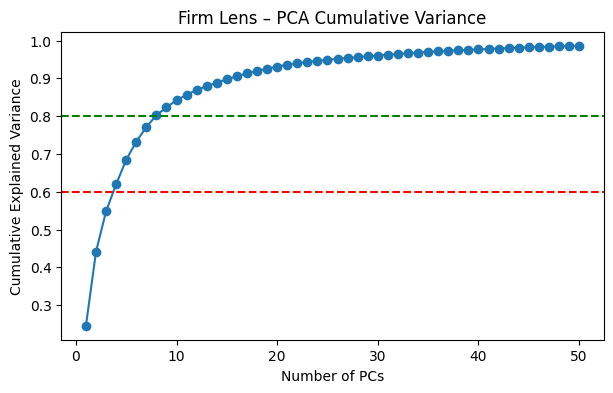


Top drivers of PC1:


,PC1
IT spend Missing,0.387158
IT Budget Missing,0.387112
Revenue (USD) Missing,0.387072
Entity Type_Branch,0.370698
Market Value (USD) Missing,0.352868
CompanyAge_transformed,0.271477
Entity Type_Subsidiary,0.254303
Employees Total Missing,0.203771
Employees Total_transformed,0.174300
Employees Single Site_transformed,0.174300



Top drivers of PC2:


,PC2
IT Budget_transformed,0.500758
IT spend_transformed,0.500474
Revenue (USD)_transformed,0.479264
Market Value (USD)_transformed,0.451851
Employees Total_transformed,0.142625
Employees Single Site_transformed,0.142625
CompanyAge_transformed,0.102810
Entity Type_Subsidiary,0.082633
Entity Type_Branch,0.044627
Entity Type_Parent,0.038006



Top drivers of PC3:


,PC3
CompanyAge_transformed,0.772551
Employees Total_transformed,0.280143
Employees Single Site_transformed,0.280143
Entity Type_Subsidiary,0.275471
Employees Total Missing,0.192608
Corporate Family Members_transformed,0.164848
Entity Type_Parent,0.159680
Entity Type_Branch,0.115791
SIC_2D_73,0.110643
Market Value (USD) Missing,0.107392


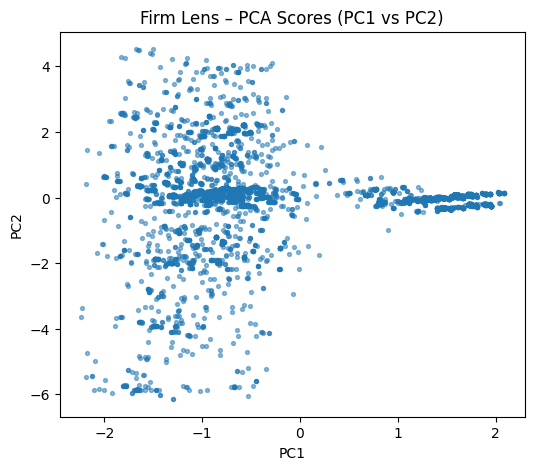

,k,silhouette
0,2,0.283909
1,3,0.313145
2,4,0.269912
3,5,0.270757
4,6,0.278251
5,7,0.268209
6,8,0.270602
7,9,0.274430
8,10,0.276858


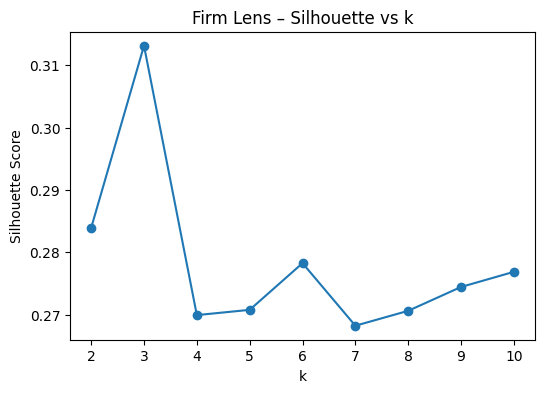


================ Tech Lens =================
Shape: (8559, 92)


,PC,ExplainedVariance,CumulativeVariance
0,1,0.231233,0.231233
1,2,0.187745,0.418978
2,3,0.124786,0.543764
3,4,0.085479,0.629243
4,5,0.047652,0.676894
5,6,0.042896,0.719791
6,7,0.034865,0.754656
7,8,0.025159,0.779815
8,9,0.019107,0.798921
9,10,0.018459,0.817380


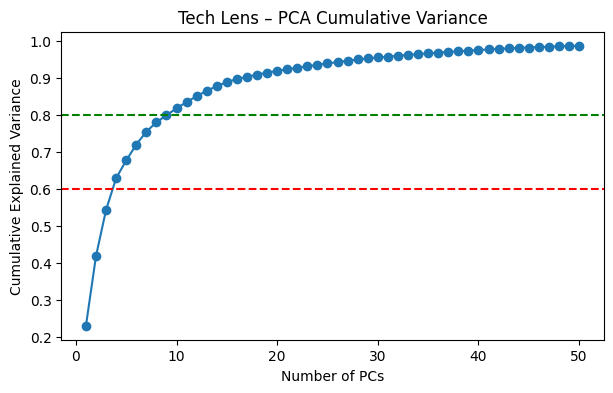


Top drivers of PC1:


,PC1
IT Budget_transformed,0.633801
IT spend_transformed,0.633513
ITSpendPerEmployee_transformed,0.417655
IT spend Missing,0.085934
IT Budget Missing,0.085917
Employees Total Missing,0.061504
Employees Total_transformed,0.049671
SIC_2D_65,0.018527
SIC_2D_50,0.014283
ServersPer100Emp_transformed,0.014273



Top drivers of PC2:


,PC2
IT spend Missing,0.563737
IT Budget Missing,0.563682
Employees Total_transformed,0.382990
Employees Total Missing,0.327517
ServersPer100Emp_transformed,0.282372
IT Budget_transformed,0.087626
IT spend_transformed,0.087619
SIC_2D_59,0.078758
SIC_2D_99,0.049438
ITSpendPerEmployee_transformed,0.042916



Top drivers of PC3:


,PC3
ServersPer100Emp_transformed,0.563125
Employees Total_transformed,0.561025
Employees Total Missing,0.373251
ITSpendPerEmployee_transformed,0.292738
IT spend Missing,0.229005
IT Budget Missing,0.228920
Ownership Type_Private,0.097465
Ownership Type_nan,0.097131
SIC_2D_73,0.096553
SIC_2D_87,0.065059


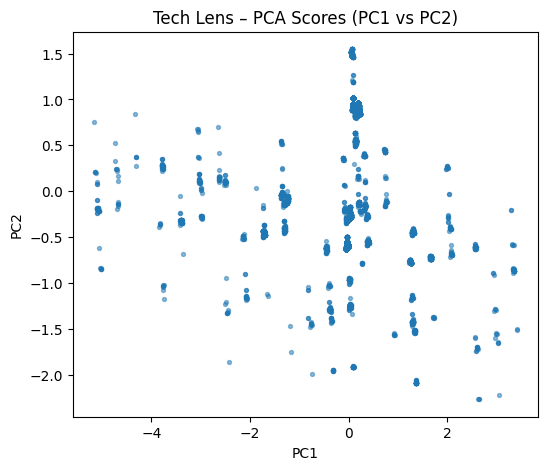

,k,silhouette
0,2,0.241886
1,3,0.281402
2,4,0.303949
3,5,0.318689
4,6,0.326813
5,7,0.349719
6,8,0.352433
7,9,0.358369
8,10,0.374799


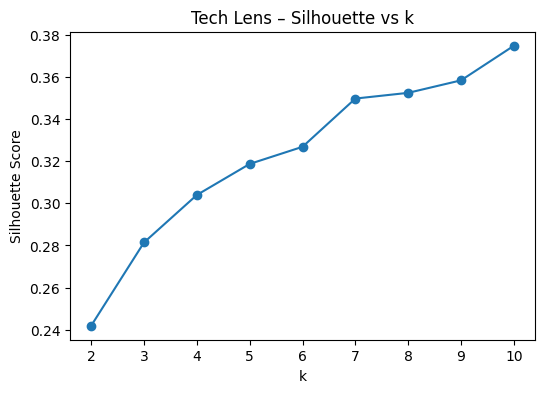


================ Complexity Lens =================
Shape: (8559, 107)


,PC,ExplainedVariance,CumulativeVariance
0,1,0.245269,0.245269
1,2,0.162916,0.408185
2,3,0.109161,0.517346
3,4,0.095271,0.612617
4,5,0.064680,0.677297
5,6,0.041875,0.719171
6,7,0.021745,0.740917
7,8,0.020224,0.761140
8,9,0.019654,0.780794
9,10,0.017825,0.798620


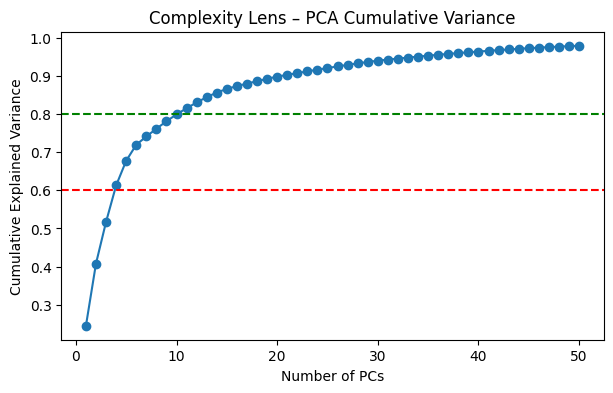


Top drivers of PC1:


,PC1
IsOwnDomesticUltimate,0.447474
IsOwnParent,0.447315
IsOwnGlobalUltimate,0.447303
Entity Type_Parent,0.446819
Corporate Family Members_transformed,0.292711
Entity Type_Branch,0.260428
Entity Type_Subsidiary,0.186391
Legal Status_3.0,0.047175
SIC_2D_59,0.043455
Ownership Type_Private,0.039288



Top drivers of PC2:


,PC2
Entity Type_Subsidiary,0.592628
Corporate Family Members_transformed,0.548736
Entity Type_Branch,0.483489
Ownership Type_Private,0.127669
Ownership Type_nan,0.126624
SIC_2D_59,0.124452
Entity Type_Parent,0.109140
IsOwnParent,0.109045
IsOwnGlobalUltimate,0.108925
IsOwnDomesticUltimate,0.107358



Top drivers of PC3:


,PC3
Corporate Family Members_transformed,0.758625
Entity Type_Branch,0.443109
Entity Type_Subsidiary,0.352869
Ownership Type_Private,0.143444
Ownership Type_nan,0.141189
IsOwnDomesticUltimate,0.094143
GlobalRestricted,0.091298
DomesticRestricted,0.091298
IsOwnGlobalUltimate,0.091059
IsOwnParent,0.090835


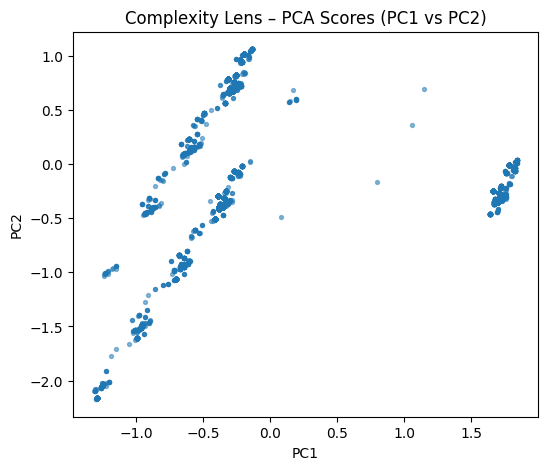

,k,silhouette
0,2,0.357682
1,3,0.341532
2,4,0.366210
3,5,0.394188
4,6,0.402980
5,7,0.405653
6,8,0.373627
7,9,0.343726
8,10,0.399384


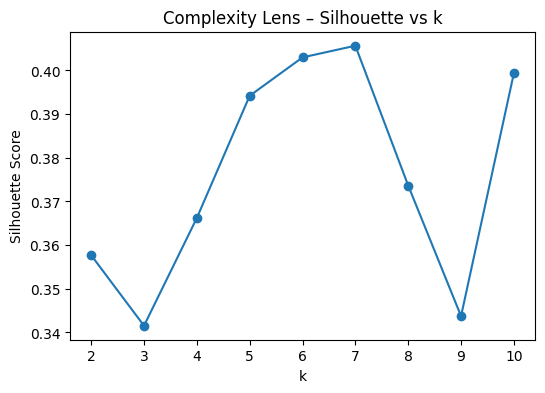

In [ ]:
out_firm = pca_cluster_diagnostics(X_firm, "Firm Lens")
out_tech = pca_cluster_diagnostics(X_tech, "Tech Lens")
out_comp = pca_cluster_diagnostics(X_comp, "Complexity Lens")


## Firm Lens — Interpretation
The Firm lens PCA reveals a clear separation between data completeness / structural form and economic scale. PC1 (≈25% variance) is dominated by missingness indicators (IT spend missing, revenue missing, market value missing) and entity structure (branch vs subsidiary vs parent), indicating that the primary axis of variation is disclosure and organisational form, not size. Firms that cluster together along PC1 tend to share similar reporting opacity and legal structure rather than similar revenues or headcount. PC2 (≈20% variance) captures true economic scale, driven by revenue, market value, and IT budget levels, while PC3 is strongly driven by company age, separating younger, fast-scaling entities from older, more established firms. The silhouette analysis peaks at k = 3 (≈0.31), suggesting coarse but meaningful archetypes rather than fine-grained segmentation.
### Implication:
For the Firm lens, clustering should prioritise interpretability over granularity. Retaining ~8–10 PCs (≈80% variance) is sufficient, but clustering should be limited to 3–4 clusters. This lens is well-suited to archetype discovery (e.g. “opaque subsidiaries”, “mature parent firms”, “young disclosed firms”) rather than high-resolution peer matching.
## Tech Lens — Interpretation
The Tech lens shows a clean and intuitive structure, with PC1 (≈23% variance) almost entirely driven by IT intensity (IT budget, IT spend, IT spend per employee). This confirms that the dominant axis reflects absolute and relative technology investment. PC2 is driven by missingness and employee scale, separating firms with incomplete IT disclosures from those with fully observable tech stacks. PC3 highlights infrastructure density, particularly servers per employee and workforce size, capturing operational deployment rather than budget magnitude. Unlike the Firm lens, the silhouette score monotonically increases with k, reaching ≈0.37 at k = 10, indicating that technology profiles are inherently multi-modal.
### Implication:
For the Tech lens, you should retain 10–12 PCs (≈80–85% variance) and prefer HDBSCAN or higher-k KMeans (k≈7–10). This lens supports fine-grained peer grouping, making it ideal for identifying under-investment risk, over-engineering, or anomalous tech-to-scale ratios. This is the strongest lens for downstream risk flagging and benchmarking.
## Complexity Lens — Interpretation
The Complexity lens exhibits the strongest clustering signal among all lenses. PC1 (≈25% variance) is dominated by ownership structure flags (own parent, own ultimate, entity type), clearly separating standalone firms from deeply nested corporate entities. PC2 and PC3 are driven by subsidiary count, corporate family size, and legal form, capturing degrees of organisational complexity. Importantly, silhouette scores peak around k = 6–7 (≈0.40–0.41), significantly higher than the other lenses, indicating well-separated, stable clusters.
### Implication:
This lens is ideal for structural segmentation. Retaining 8–10 PCs is sufficient, and clustering at k ≈ 6–7 yields interpretable groups such as “simple standalone”, “regional holding entities”, and “globally complex structures”. This lens should be treated as foundational context rather than behavioural variation

# Clustering Decision
## Firm lens
PCs kept: 8–10 PCs (≈80% cumulative variance; your curve crosses ~0.80 around PC8–PC10)

Clustering: KMeans
k: 3 (silhouette peaks at k=3 ≈ 0.31)
Intent: coarse, interpretable archetypes (opacity/structure vs scale vs age)
## Tech lens
PCs kept: 10–12 PCs (≈80–85% cumulative variance)

Clustering: HDBSCAN
silhouette improves as k increases → suggests multi-modal / density-driven structure + outliers
HDBSCAN can label “noise” (anomalies), which is useful for tech risk detection
## Complexity lens
PCs kept: 8–10 PCs (≈80% cumulative variance)

Clustering: KMeans
k: 7 (silhouette peaks around k=6–7 ≈ 0.40–0.41)
Intent: structural segmentation (standalone vs nested vs large corporate families)


In [ ]:
ID_COLS = ["DUNS Number ", "Company Sites"]

# locked PCA dimensions (choose within your “8–10 / 10–12” guideline)
FIRM_NPCS = 9
TECH_NPCS = 11
COMP_NPCS = 9

# locked KMeans ks
FIRM_K = 3
COMP_K = 7

# HDBSCAN params (reasonable starting defaults)
HDB_MIN_CLUSTER_SIZE = 80     # try 50–150 depending on how granular you want
HDB_MIN_SAMPLES = 10          # higher -> stricter, more noise




# KMEANS and HDBSCAN Clustering

In [ ]:
def compute_lens_score(df_lens, lens_name):
    df_lens_num = df_lens.select_dtypes(include=[np.number]).copy()

    # sanity check
    print(f"\n[{lens_name}] lens-score numeric columns:", df_lens_num.shape[1])
    if df_lens_num.shape[1] == 0:
        raise ValueError(f"{lens_name}: No numeric columns found for lens scoring.")

    # standardize numeric cols (robust even if already standardized)
    scaler = StandardScaler()
    Z = scaler.fit_transform(df_lens_num.values)
    Z = pd.DataFrame(Z, index=df_lens_num.index, columns=df_lens_num.columns)

    # composite score (mean of z-scores)
    score = Z.mean(axis=1)

    out = pd.DataFrame({
        f"{lens_name}_score": score,
        f"{lens_name}_pct_overall": score.rank(pct=True)
    }, index=df_lens.index)

    return out

def kmeans_on_pca(X, lens_name, n_pcs, k):
    print(f"\n=== {lens_name} | PCA({n_pcs}) + KMeans(k={k}) ===")

    pca = PCA(n_components=n_pcs, random_state=42)
    X_pca = pca.fit_transform(X)

    cum_var = pca.explained_variance_ratio_.sum()
    print(f"{lens_name}: cumulative explained variance (first {n_pcs} PCs) = {cum_var:.3f}")

    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    print(f"{lens_name}: silhouette = {sil:.3f}")

    # quick interpretable output: cluster sizes
    sizes = pd.Series(labels).value_counts().sort_index()
    print(f"{lens_name}: cluster sizes:\n{sizes}")

    # quick plot: PC1 vs PC2 coloured by cluster
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=8, alpha=0.6)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{lens_name}: PCA scatter (clusters)")
    plt.show()

    return labels, pca, X_pca

def hdbscan_on_pca(X, lens_name, n_pcs, min_cluster_size=80, min_samples=10):
    print(f"\n=== {lens_name} | PCA({n_pcs}) + HDBSCAN ===")

    pca = PCA(n_components=n_pcs, random_state=42)
    X_pca = pca.fit_transform(X)

    cum_var = pca.explained_variance_ratio_.sum()
    print(f"{lens_name}: cumulative explained variance (first {n_pcs} PCs) = {cum_var:.3f}")

    try:
        import hdbscan
    except ImportError:
        raise ImportError(
            "You need the 'hdbscan' package.\n"
            "Run: pip install hdbscan\n"
            "Then re-run this cell."
        )

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples
    )
    labels = clusterer.fit_predict(X_pca)

    # HDBSCAN label -1 = noise
    sizes = pd.Series(labels).value_counts().sort_index()
    print(f"{lens_name}: cluster sizes (note -1 = noise):\n{sizes}")

    noise_rate = (labels == -1).mean()
    print(f"{lens_name}: noise rate = {noise_rate:.3f}")

    # silhouette (only for non-noise points, otherwise misleading)
    mask = labels != -1
    if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
        sil = silhouette_score(X_pca[mask], labels[mask])
        print(f"{lens_name}: silhouette (excluding noise) = {sil:.3f}")
    else:
        print(f"{lens_name}: silhouette not computed (too few clusters after removing noise).")

    # plot
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=8, alpha=0.6)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{lens_name}: PCA scatter (HDBSCAN labels, -1=noise)")
    plt.show()

    return labels, pca, X_pca, clusterer


# Adding Scores per lens (overall and within cluster)


=== firm | PCA(9) + KMeans(k=3) ===
firm: cumulative explained variance (first 9 PCs) = 0.823
firm: silhouette = 0.349
firm: cluster sizes:
0    3317
1    4671
2     571
Name: count, dtype: int64


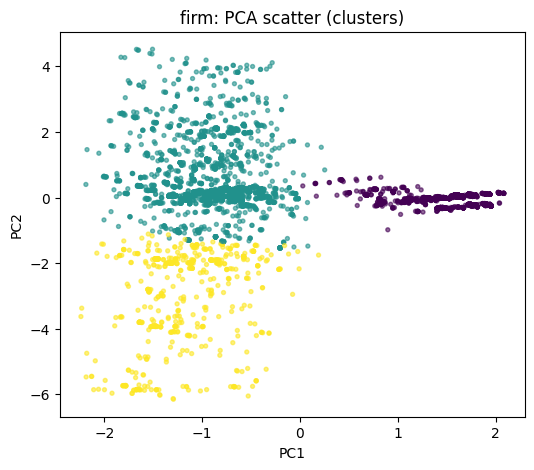


[firm] lens-score numeric columns: 14


,DUNS Number,Company Sites,firm_cluster,firm_score,firm_pct_overall,firm_pct_within_cluster
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",0,-0.000948,0.520972,0.115767
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",1,-0.415967,0.155041,0.172126
2,728834216,Keshan Shengren Potato Industry Processing Co....,1,0.014405,0.532539,0.765361
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,1,-0.290629,0.246524,0.333976
4,728889244,Zuoquan County Tianxin Real Estate Development...,1,-0.469962,0.123379,0.117534


Firm output columns: ['DUNS Number ', 'Company Sites', 'firm_cluster', 'firm_score', 'firm_pct_overall', 'firm_pct_within_cluster']

=== tech | PCA(11) + HDBSCAN ===
tech: cumulative explained variance (first 11 PCs) = 0.834
tech: cluster sizes (note -1 = noise):
-1     1173
 0       96
 1      550
 2      110
 3      248
 4       94
 5      148
 6      248
 7      224
 8      121
 9      765
 10     298
 11      99
 12     426
 13     179
 14     241
 15     119
 16      83
 17     419
 18     139
 19      93
 20     340
 21     128
 22     110
 23     102
 24     159
 25     146
 26     135
 27     133
 28     170
 29     148
 30     635
 31      99
 32     381
Name: count, dtype: int64
tech: noise rate = 0.137
tech: silhouette (excluding noise) = 0.697


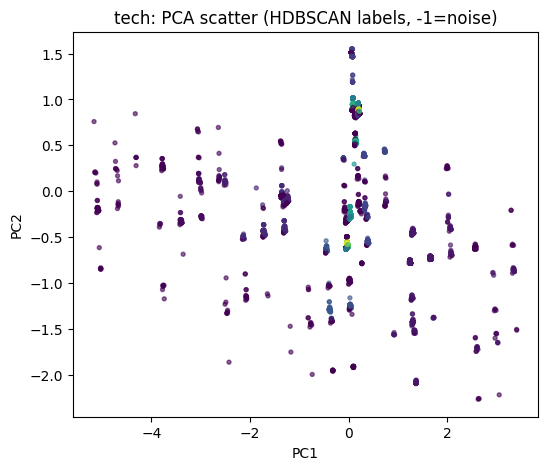


[tech] lens-score numeric columns: 8


,DUNS Number,Company Sites,tech_cluster,tech_score,tech_pct_overall,tech_pct_within_cluster
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",20,0.032573,0.520154,0.439706
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",3,-0.899975,0.041594,0.294355
2,728834216,Keshan Shengren Potato Industry Processing Co....,7,-0.376978,0.175079,0.033482
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,2,-0.513126,0.112805,0.904545
4,728889244,Zuoquan County Tianxin Real Estate Development...,6,0.061654,0.560112,0.471774


Tech output columns: ['DUNS Number ', 'Company Sites', 'tech_cluster', 'tech_score', 'tech_pct_overall', 'tech_pct_within_cluster']

=== comp | PCA(9) + KMeans(k=7) ===
comp: cumulative explained variance (first 9 PCs) = 0.781
comp: silhouette = 0.493
comp: cluster sizes:
0    1367
1    2613
2    2465
3     772
4     524
5     561
6     257
Name: count, dtype: int64


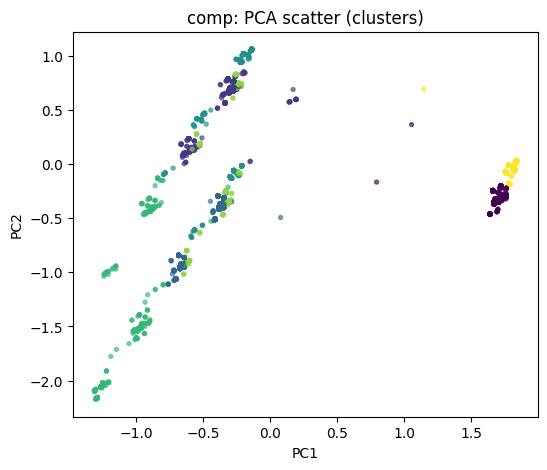


[comp] lens-score numeric columns: 7


,DUNS Number,Company Sites,comp_cluster,comp_score,comp_pct_overall,comp_pct_within_cluster
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",2,-0.202463,0.543580,0.672008
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",1,-0.355958,0.109359,0.114619
2,728834216,Keshan Shengren Potato Industry Processing Co....,1,-0.268797,0.420960,0.579602
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,0,0.756444,0.915294,0.636796
4,728889244,Zuoquan County Tianxin Real Estate Development...,0,0.735618,0.856467,0.309071


Complexity output columns: ['DUNS Number ', 'Company Sites', 'comp_cluster', 'comp_score', 'comp_pct_overall', 'comp_pct_within_cluster']


In [ ]:
# --- Firm (KMeans) ---
firm_labels, firm_pca, firm_Xpca = kmeans_on_pca(X_firm, "firm", FIRM_NPCS, FIRM_K)
firm_score = compute_lens_score(df_firm, "firm")

firm_out = df_clean[ID_COLS].copy()
firm_out["firm_cluster"] = firm_labels
firm_out = firm_out.join(firm_score)

firm_out["firm_pct_within_cluster"] = (
    firm_out.groupby("firm_cluster")["firm_score"].rank(pct=True)
)

display(firm_out.head())
print("Firm output columns:", firm_out.columns.tolist())


# --- Tech (HDBSCAN) ---
tech_labels, tech_pca, tech_Xpca, tech_clusterer = hdbscan_on_pca(
    X_tech, "tech", TECH_NPCS,
    min_cluster_size=HDB_MIN_CLUSTER_SIZE,
    min_samples=HDB_MIN_SAMPLES
)
tech_score = compute_lens_score(df_tech, "tech")

tech_out = df_clean[ID_COLS].copy()
tech_out["tech_cluster"] = tech_labels
tech_out = tech_out.join(tech_score)

# peer percentile only makes sense for non-noise groups; keep NaN for noise
tech_out["tech_pct_within_cluster"] = np.nan
mask = tech_out["tech_cluster"] != -1
tech_out.loc[mask, "tech_pct_within_cluster"] = (
    tech_out.loc[mask].groupby("tech_cluster")["tech_score"].rank(pct=True)
)

display(tech_out.head())
print("Tech output columns:", tech_out.columns.tolist())


# --- Complexity (KMeans) ---
comp_labels, comp_pca, comp_Xpca = kmeans_on_pca(X_comp, "comp", COMP_NPCS, COMP_K)
comp_score = compute_lens_score(df_comp, "comp")

comp_out = df_clean[ID_COLS].copy()
comp_out["comp_cluster"] = comp_labels
comp_out = comp_out.join(comp_score)

comp_out["comp_pct_within_cluster"] = (
    comp_out.groupby("comp_cluster")["comp_score"].rank(pct=True)
)

display(comp_out.head())
print("Complexity output columns:", comp_out.columns.tolist())


## Interpretation on the scores
Firm_score:
Positive represents larger, more transparent entities
Negative represents smaller, less disclosed subsidiaries/branches

Tech_score:
Positive represents higher IT intensity and observable tech footprint
Negative represents lower IT spend, higher employee count or missing IT disclosures

Comp_score:
Positive represents nested, holding-type or globally complex firms
Negative represents standalone or simple entitites

Pct_overall: Used for portfolio wide ranking
Pct_within_cluster: Used for anomaly detection/ risk detection within its peers

## Contradiction Detection
When lenses disagree in a meaningful way, we can draw greater insights of the firm.

E.g. Scale - Tech contradiction (large and complex firm but weak tech posture) if we see a difference between the company's firm_score high but tech_score low. This indicates IT Underinvestment Risk.

E.g. Complexity - Disclosure contradiction (organisational complexity without commensurate transparency) if comp_score is high but firm_score is low. This indicates Data Opacity Risk.

E.g. Scale - Tech contradiction
(young fast scaling firm with unusually heavy or light IT) if tech_score is extreme but firm_score is low. This can indicate over-engineered early stage firms or fast scaling firm with fragile tech foundations.

# UMAPS to visualize clusters

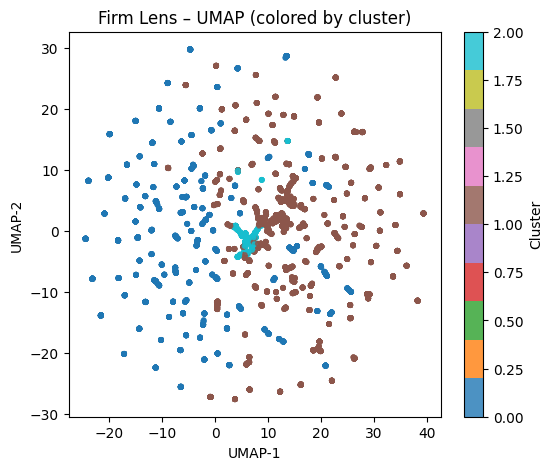

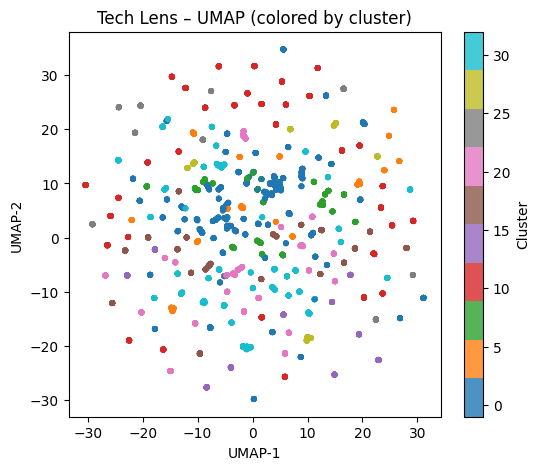

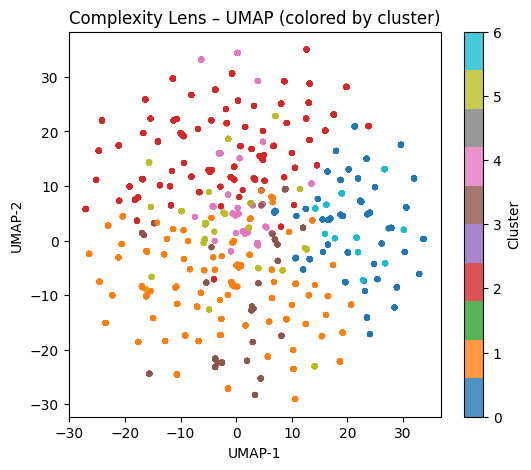

array([[-16.340172  ,  25.853117  ],
       [ -0.69591826,  -0.3729671 ],
       [ 16.489952  , -10.207772  ],
       ...,
       [  0.42727214,   4.9296875 ],
       [  3.894387  ,  29.235317  ],
       [ -0.7006835 ,   4.963827  ]], dtype=float32)

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

def run_umap(X_pca, labels, lens_name, n_neighbors=15, min_dist=0.1):
    umap = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=42
    )
    X_umap = umap.fit_transform(X_pca)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=labels,
        cmap="tab10",
        s=10,
        alpha=0.8
    )
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"{lens_name} – UMAP (colored by cluster)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

    return X_umap

# Firm
run_umap(firm_Xpca[:, :10], firm_labels, "Firm Lens")

# Tech (HDBSCAN labels, -1 = noise)
run_umap(tech_Xpca[:, :12], tech_labels, "Tech Lens")

# Complexity
run_umap(comp_Xpca[:, :10], comp_labels, "Complexity Lens")

# Merging outputs into master interpretation table

In [ ]:
import numpy as np
import pandas as pd

ID_COLS = ["DUNS Number ", "Company Sites"]

# firm_out, tech_out, comp_out already exist from your pipeline
# Ensure IDs are consistent dtype
for t in [firm_out, tech_out, comp_out]:
    t[ID_COLS[0]] = t[ID_COLS[0]].astype(str)
    t[ID_COLS[1]] = t[ID_COLS[1]].astype(str)

master = firm_out.merge(
    tech_out[ID_COLS + ["tech_cluster","tech_score","tech_pct_overall","tech_pct_within_cluster"]],
    on=ID_COLS,
    how="left"
).merge(
    comp_out[ID_COLS + ["comp_cluster","comp_score","comp_pct_overall","comp_pct_within_cluster"]],
    on=ID_COLS,
    how="left"
)

print(master.shape)
master.head()


(8559, 14)


,DUNS Number,Company Sites,firm_cluster,firm_score,firm_pct_overall,firm_pct_within_cluster,tech_cluster,tech_score,tech_pct_overall,tech_pct_within_cluster,comp_cluster,comp_score,comp_pct_overall,comp_pct_within_cluster
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",0,-0.000948,0.520972,0.115767,20,0.032573,0.520154,0.439706,2,-0.202463,0.543580,0.672008
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",1,-0.415967,0.155041,0.172126,3,-0.899975,0.041594,0.294355,1,-0.355958,0.109359,0.114619
2,728834216,Keshan Shengren Potato Industry Processing Co....,1,0.014405,0.532539,0.765361,7,-0.376978,0.175079,0.033482,1,-0.268797,0.420960,0.579602
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,1,-0.290629,0.246524,0.333976,2,-0.513126,0.112805,0.904545,0,0.756444,0.915294,0.636796
4,728889244,Zuoquan County Tianxin Real Estate Development...,1,-0.469962,0.123379,0.117534,6,0.061654,0.560112,0.471774,0,0.735618,0.856467,0.309071


In [ ]:
# Convert percentile (0-1) -> quartile 1..4
# (Clamp 1.0 edge case to avoid qcut duplicates)
def pct_to_quartile(p):
    p = np.clip(p, 0, 0.999999)
    # Let qcut generate its own labels (intervals)
    cut_series = pd.qcut(p, 4, duplicates='drop')
    # Get unique categories (bins) created by qcut
    categories = cut_series.cat.categories
    # Create a mapping from category interval to a sequential integer (1-indexed)
    label_mapping = {cat: i + 1 for i, cat in enumerate(categories)}
    # Apply the mapping
    return cut_series.map(label_mapping)

master["q_firm"] = pct_to_quartile(master["firm_pct_overall"]).astype(int)
master["q_tech"] = pct_to_quartile(master["tech_pct_overall"]).astype(int)
master["q_comp"] = pct_to_quartile(master["comp_pct_overall"]).astype(int)

master[["firm_pct_overall","q_firm","tech_pct_overall","q_tech","comp_pct_overall","q_comp"]].head()

,firm_pct_overall,q_firm,tech_pct_overall,q_tech,comp_pct_overall,q_comp
0,0.520972,3,0.520154,2,0.543580,3
1,0.155041,1,0.041594,1,0.109359,1
2,0.532539,3,0.175079,1,0.420960,2
3,0.246524,1,0.112805,1,0.915294,4
4,0.123379,1,0.560112,3,0.856467,4


In [ ]:
# Contradiction Detection
master["gap_firm_tech"] = (master["firm_pct_overall"] - master["tech_pct_overall"]).abs()
master["gap_firm_comp"] = (master["firm_pct_overall"] - master["comp_pct_overall"]).abs()
master["gap_tech_comp"] = (master["tech_pct_overall"] - master["comp_pct_overall"]).abs()

gap_cols = ["gap_firm_tech", "gap_firm_comp", "gap_tech_comp"]
master["contradiction_strength"] = master[gap_cols].max(axis=1)

pair_map = {
    "gap_firm_tech": "firm vs tech",
    "gap_firm_comp": "firm vs complexity",
    "gap_tech_comp": "tech vs complexity"
}
master["contradiction_pair"] = master[gap_cols].idxmax(axis=1).map(pair_map)

# Severity tiers (tune these thresholds later)
master["contradiction_level"] = np.select(
    [
        master["contradiction_strength"] >= 0.60,
        master["contradiction_strength"] >= 0.30,
    ],
    ["strong", "moderate"],
    default="none"
)

master["contradiction_moderate"] = (master["contradiction_level"].isin(["moderate", "strong"])).astype(int)
master["contradiction_strong"] = (master["contradiction_level"] == "strong").astype(int)


master["diffq_firm_tech"] = (master["q_firm"] - master["q_tech"]).abs()
master["diffq_firm_comp"] = (master["q_firm"] - master["q_comp"]).abs()
master["diffq_tech_comp"] = (master["q_tech"] - master["q_comp"]).abs()

diffq_cols = ["diffq_firm_tech","diffq_firm_comp","diffq_tech_comp"]
master["contradiction_quartile_maxdiff"] = master[diffq_cols].max(axis=1)

cols_to_view = [
    ID_COLS[0], ID_COLS[1],
    "firm_cluster","firm_score","firm_pct_overall","q_firm",
    "tech_cluster","tech_score","tech_pct_overall","q_tech",
    "comp_cluster","comp_score","comp_pct_overall","q_comp",
    "contradiction_pair","contradiction_strength","contradiction_level",
    "contradiction_quartile_maxdiff"
]
display(master[cols_to_view].head(10))

display(
    master["contradiction_level"]
    .value_counts(dropna=False)
    .to_frame("count")
)

# Top contradictions to eyeball
display(
    master.sort_values("contradiction_strength", ascending=False)[cols_to_view]
    .head(20)
)


,DUNS Number,Company Sites,firm_cluster,firm_score,firm_pct_overall,q_firm,tech_cluster,tech_score,tech_pct_overall,q_tech,comp_cluster,comp_score,comp_pct_overall,q_comp,contradiction_pair,contradiction_strength,contradiction_level,contradiction_quartile_maxdiff
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",0,-0.000948,0.520972,3,20,0.032573,0.520154,2,2,-0.202463,0.543580,3,tech vs complexity,0.023426,none,1
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",1,-0.415967,0.155041,1,3,-0.899975,0.041594,1,1,-0.355958,0.109359,1,firm vs tech,0.113448,none,0
2,728834216,Keshan Shengren Potato Industry Processing Co....,1,0.014405,0.532539,3,7,-0.376978,0.175079,1,1,-0.268797,0.420960,2,firm vs tech,0.357460,moderate,2
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,1,-0.290629,0.246524,1,2,-0.513126,0.112805,1,0,0.756444,0.915294,4,tech vs complexity,0.802489,strong,3
4,728889244,Zuoquan County Tianxin Real Estate Development...,1,-0.469962,0.123379,1,6,0.061654,0.560112,3,0,0.735618,0.856467,4,firm vs complexity,0.733088,strong,3
5,547827642,Zuoquan County People's Hospital ...,1,1.076543,0.983176,4,1,0.624601,0.729875,3,6,2.084265,0.992639,4,tech vs complexity,0.262764,none,1
6,728864458,"Zuoquan County Huixiang Meihua Co., Ltd. ...",1,0.276909,0.647506,3,-1,-0.277446,0.224793,1,1,-0.355958,0.109359,1,firm vs complexity,0.538147,moderate,2
7,547765600,Shiliuyuan Branch of Beijing Zuolin Youshe Cat...,2,-1.031530,0.013670,1,0,-1.272334,0.014488,1,2,-0.355958,0.109359,1,firm vs complexity,0.095689,none,0
8,639561763,"Zhijin County Zhongba Coal Supply Co., Ltd. ...",1,0.159147,0.608716,3,-1,-0.277446,0.224793,1,1,-0.355958,0.109359,1,firm vs complexity,0.499357,moderate,2
9,639511811,"Zunyi Yurui Construction Engineering Co., Ltd....",0,0.529869,0.704930,3,10,1.276550,0.870662,3,2,-0.355958,0.109359,1,tech vs complexity,0.761304,strong,2


,count
contradiction_level,
none,3949
moderate,2800
strong,1810


,DUNS Number,Company Sites,firm_cluster,firm_score,firm_pct_overall,q_firm,tech_cluster,tech_score,tech_pct_overall,q_tech,comp_cluster,comp_score,comp_pct_overall,q_comp,contradiction_pair,contradiction_strength,contradiction_level,contradiction_quartile_maxdiff
141,547744839,Zigong Da'an District Da'an Primary School ...,2,-0.005119,0.518402,3,-1,-1.144209,0.021030,1,6,2.084265,0.992639,4,tech vs complexity,0.971609,strong,3
1706,547848747,Zhong County Maguan Town Huangqin Primary Scho...,2,-0.103386,0.424465,2,-1,-1.074881,0.026639,1,6,2.084265,0.992639,4,tech vs complexity,0.966001,strong,3
4301,547798813,"Juvenile Sports Club, Sports College, Yunnan N...",2,-0.311109,0.222573,1,0,-1.187976,0.018343,1,1,1.191885,0.983292,4,tech vs complexity,0.964949,strong,3
307,547921506,"Zhuhai Yuntong Aviation Service Co., Ltd. ...",2,-0.001752,0.520505,3,3,-0.993323,0.033999,1,0,2.345737,0.996962,4,tech vs complexity,0.962963,strong,3
941,547914253,Zhongshan Shiqi District Caring Service Center...,2,-1.154865,0.009113,1,0,-1.215254,0.017058,1,0,0.873235,0.969272,4,firm vs complexity,0.960159,strong,3
7935,728764681,Xingyi Mantang Qianbao Gold Shop ...,2,-1.106575,0.010983,1,0,-1.343653,0.013202,1,0,0.873235,0.969272,4,firm vs complexity,0.958290,strong,3
7214,547823839,Xinye County Wangji Consumption Cooperative So...,2,-0.718329,0.045449,1,0,-1.221705,0.016941,1,0,0.889113,0.972193,4,tech vs complexity,0.955252,strong,3
8275,547857046,"Xianning Nanshan Construction Engineering Co.,...",2,-0.892001,0.024536,1,0,-1.205489,0.017759,1,0,0.891953,0.972544,4,tech vs complexity,0.954784,strong,3
8195,547847128,Xiaochang County Doushan Township Supply And M...,2,-0.803488,0.033415,1,-1,-1.545245,0.005842,1,0,0.835978,0.960451,4,tech vs complexity,0.954609,strong,3
6015,728900588,Yinchuan Yiwenfan Internet Cafe ...,2,-0.999553,0.015189,1,-1,-0.544206,0.096857,1,0,0.873235,0.969272,4,firm vs complexity,0.954083,strong,3


## Risk Archetypes

In [ ]:
# 1) Scale Imbalance Risk (Firm high, Tech low)
master["risk_scale_imbalance"] = (
    (master["firm_pct_overall"] >= 0.75) &
    (master["tech_pct_overall"] <= 0.25)
).astype(int)

master["risk_scale_imbalance_why"] = np.where(
    master["risk_scale_imbalance"].eq(1),
    "Firm percentile is high while Tech percentile is low (scale not matched by operational/tech intensity).",
    ""
)

# 2) IT Underinvestment Risk (Tech low relative to Firm)
master["risk_it_underinvestment"] = (
    (master["tech_pct_overall"] <= 0.25) &
    (master["firm_pct_overall"] >= 0.50)
).astype(int)

master["risk_it_underinvestment_why"] = np.where(
    master["risk_it_underinvestment"].eq(1),
    "Tech percentile is bottom-range while Firm percentile is mid/high (possible underinvestment vs peers).",
    ""
)

# 3) Complexity Mismatch Risk (Complexity high, Firm low)
master["risk_complexity_mismatch"] = (
    (master["comp_pct_overall"] >= 0.75) &
    (master["firm_pct_overall"] <= 0.25)
).astype(int)

master["risk_complexity_mismatch_why"] = np.where(
    master["risk_complexity_mismatch"].eq(1),
    "Complexity percentile is high while Firm percentile is low (structure heavier than operational scale).",
    ""
)

# 4) Data Opacity Risk (proxy: strong contradiction OR extreme inconsistency)
# Since we're not using raw missingness columns here, we use contradiction as an interpretability risk proxy.
master["risk_data_opacity"] = (
    (master["contradiction_quartile_maxdiff"] >= 3)  # strongest quartile mismatch
).astype(int)

master["risk_data_opacity_why"] = np.where(
    master["risk_data_opacity"].eq(1),
    "Strong cross-lens contradiction (Q1 vs Q4) suggests inconsistent signals; interpret with caution.",
    ""
)

# -------------------------
# Compact risk tags for UI + LLM
# -------------------------
risk_cols = [
    "risk_scale_imbalance",
    "risk_it_underinvestment",
    "risk_complexity_mismatch",
    "risk_data_opacity",
]

risk_name_map = {
    "risk_scale_imbalance": "Scale Imbalance Risk",
    "risk_it_underinvestment": "IT Underinvestment Risk",
    "risk_complexity_mismatch": "Complexity Mismatch Risk",
    "risk_data_opacity": "Data Opacity Risk",
}

master["risk_tags"] = master[risk_cols].apply(
    lambda r: [risk_name_map[c] for c in risk_cols if r[c] == 1],
    axis=1
)

# Quick sanity check counts
print(master[risk_cols].sum().sort_values(ascending=False))
master[[ "DUNS Number ", "Company Sites", "risk_tags" ]].head()


risk_data_opacity           1276
risk_complexity_mismatch     716
risk_it_underinvestment      142
risk_scale_imbalance           6
dtype: int64


,DUNS Number,Company Sites,risk_tags
0,639677726,"Zyf Lopsking Material Technology Co., Ltd. No....",[]
1,547756179,"Beijing Kaishi Lide Commerce And Trade Co., Lt...",[]
2,728834216,Keshan Shengren Potato Industry Processing Co....,[IT Underinvestment Risk]
3,728791839,Zuoquan County Yuanfeng Agriculture Technology...,"[Complexity Mismatch Risk, Data Opacity Risk]"
4,728889244,Zuoquan County Tianxin Real Estate Development...,"[Complexity Mismatch Risk, Data Opacity Risk]"


# Building the dataset for LLM

In [ ]:
DESC_COLS = ["DUNS Number ","Company Description","SIC Description"]
df_clean[DESC_COLS[0]] = df_clean[DESC_COLS[0]].astype(str)
master = master.merge(df_clean[DESC_COLS], on="DUNS Number ", how="left")
def clean_text(s, max_len=600):
    if pd.isna(s):
        return ""
    s = str(s).strip()
    s = s.replace("\n", " ").replace("\r", " ")
    s = " ".join(s.split())
    return s[:max_len]

master["Company Description_clean"] = master["Company Description"].apply(clean_text)
master["SIC Description_clean"] = master["SIC Description"].apply(clean_text)


In [ ]:
def build_company_payload(row):
    firm_pct = int(round(row["firm_pct_overall"] * 100))
    tech_pct = int(round(row["tech_pct_overall"] * 100))
    comp_pct = int(round(row["comp_pct_overall"] * 100))

    firm_pct_c = int(round(row.get("firm_pct_within_cluster", np.nan) * 100))
    tech_pct_c = int(round(row.get("tech_pct_within_cluster", np.nan) * 100))
    comp_pct_c = int(round(row.get("comp_pct_within_cluster", np.nan) * 100))

    risks = row["risk_tags"]
    risks_text = ", ".join(risks) if len(risks) > 0 else "None flagged"

    desc = row.get("Company Description_clean", "")
    sic_desc = row.get("SIC Description_clean", "")
    return f"""
Company:
- DUNS: {row['DUNS Number ']}
- Name: {row['Company Sites']}

Business Description:
{desc if desc else "[Not provided]"}

Industry (SIC):
{sic_desc if sic_desc else "[Not provided]"}

Lens Clusters:
- Firm cluster: {row['firm_cluster']}
- Tech cluster: {row['tech_cluster']}
- Complexity cluster: {row['comp_cluster']}

Lens Position (Overall):
- Firm: pct={firm_pct} (q{row['q_firm']})
- Tech: pct={tech_pct} (q{row['q_tech']})
- Complexity: pct={comp_pct} (q{row['q_comp']})

Lens Position (Within Cluster) [optional]:
- Firm within cluster: {firm_pct_c if firm_pct_c is not None else "[NA]"}
- Tech within cluster: {tech_pct_c if tech_pct_c is not None else "[NA]"}
- Complexity within cluster: {comp_pct_c if comp_pct_c is not None else "[NA]"}

Contradiction:
- pair: {row['contradiction_pair']}
- level: {row['contradiction_level']}
- quartile diff: {row['contradiction_quartile_maxdiff']}

Risk Flags:
- {risks_text}
""".strip()


# Multi step prompt flow

In [ ]:
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

step1_facts_prompt = PromptTemplate.from_template("""
You are an analyst assistant.

Task:
Extract ONLY the key facts from the Data section.
No interpretation. No recommendations.

Rules:
- Use ONLY the Data section.
- If a field is missing, write "[Not provided]".
- Keep it short.

Output Format (exact):
Company:
Industry:
Clusters:
Lens Positions (overall):
Contradiction:
Risk Flags:

Data:
{data}
""".strip())


In [ ]:
example_prompt = PromptTemplate.from_template(
    "Data:\n{data}\n\nOutput:\n{profile}\n"
)

examples = [
    {
        "data": """
Company:
- DUNS: 123
- Name: Example Holdings

Business Description:
[Not provided]

Industry (SIC):
Industrial services

Lens Clusters:
- Firm cluster: 1
- Tech cluster: 7
- Complexity cluster: 5

Lens Position (Overall):
- Firm: pct=82 (q4)
- Tech: pct=18 (q1)
- Complexity: pct=77 (q4)

Contradiction:
- pair: firm vs tech
- level: strong
- quartile diff: 3

Risk Flags:
- Scale Imbalance Risk, IT Underinvestment Risk
""".strip(),
        "profile": """
1) Cluster + Lens Summary
- Firm position is high (pct=82, q4) while Tech position is low (pct=18, q1).
- Complexity position is high (pct=77, q4), consistent with a more layered structure than typical firms.
- The main mismatch is firm vs tech (quartile diff=3), meaning scale/structure signals do not align with tech intensity.

2) Key Risks
- Scale Imbalance Risk: High firm position paired with low tech position suggests scale not matched by operational/tech intensity relative to peers.
- IT Underinvestment Risk: Tech is bottom-range while firm is mid/high, consistent with underinvestment vs similar-scale firms.

3) Recommended Next Checks
- Check whether low Tech reflects true underinvestment or measurement gaps (e.g., missing IT budget/spend fields).
- Compare this company against peers within the same Firm cluster and SIC category for context.
""".strip()
    }
]

step2_interpret_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="""
You are a B2B company intelligence analyst.

Task:
Given peer-based clustering results across Firm, Technology, and Complexity lenses,
produce an interpretable business assessment.

Interpretation Rules:
- Use ONLY the provided data.
- Do NOT use external market knowledge.
- You MAY interpret what relative positioning implies in a peer context.
- Avoid restating numbers; explain what they mean comparatively.
- If signals are weak or median, explain the implication of *lack of differentiation*.

Analytical Guidance:
- Clusters represent peer archetypes, not performance rankings.
- Percentiles indicate relative positioning, not absolute quality.
- Absence of risk flags is itself an interpretable outcome.
- Contradictions signal structural tension; lack of contradiction signals coherence.

Output Format:
1) Peer-Based Positioning Summary
   - How this company compares to similar firms across lenses
2) Structural Signals & Implications
   - What the lens alignment suggests about the company’s operating profile
3) Risk & Consistency Assessment
   - Explain why risks are or are not flagged
4) Suggested Analytical Follow-Ups
   - What a user should examine next (data checks, peer comparison, not actions)

Tone:
Analytical, neutral, decision-support oriented.
""".strip(),
    suffix="\nData:\n{data}\n\nOutput:\n",
    input_variables=["data"]
)


In [ ]:
step3_ui_prompt = PromptTemplate.from_template("""
You write UI-ready summaries for a company intelligence dashboard.

Task:
Rewrite the analysis below into a compact, user-facing card.

Rules:
- Use ONLY the provided text.
- Keep it neutral, no hype.
- Maximum 120 words.
- Include 1 short title line.

Output format:
Title:
Summary:

Text:
{analysis}
""".strip())


# Integrating LLM

In [ ]:
!pip install langchain langchain-core langchain-community langchain-huggingface huggingface_hub


In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import HuggingFaceEndpoint , ChatHuggingFace
from google.colab import userdata

In [ ]:
try: ## Double check that you have set up your HF API token first
    HF_TOKEN = userdata.get('HF_TOKEN')
    if HF_TOKEN is None:
        raise ValueError
except:
    raise ValueError("Please set up HF_TOKEN in Colab secrets")

model = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2", ## find the model that you want to use from HuggingFace
    max_new_tokens = 512, ## The number of tokens that the LLM is allowed to generate in its response
    temperature = 0, ## 0 = deterministic/consistent output, higher = more creative/random
    huggingfacehub_api_token=HF_TOKEN ## your api key to send requests
)

llm = ChatHuggingFace(llm = model) ## This is a Chat Wrapper to ensure that the LLM is able to engage in a conversation

In [ ]:
i=10
# 1) Build data payload from your master row
payload = build_company_payload(master.loc[i])   # choose i, or loop

# 2) Step 1: facts
facts = llm.invoke(step1_facts_prompt.format(data=payload)).content

# 3) Step 2: interpretation (few-shot)
analysis = llm.invoke(step2_interpret_prompt.format(data=facts)).content

# 4) Step 3: UI card (optional)
ui_card = llm.invoke(step3_ui_prompt.format(analysis=analysis)).content

print("==== FACTS ====")
print(facts)
print("\n==== ANALYSIS ====")
print(analysis)
print("\n==== UI CARD ====")
print(ui_card)


==== FACTS ====
 Company: Huichuan Branch of Zunyi Yongxin Metalware Coating Co., Ltd. (DUNS: 547784463)
Industry: Manufacturing of prefabricated metal buildings (SIC)
Clusters: firm cluster: 1, tech cluster: 32, complexity cluster: 5
Lens Positions (overall): firm: pct=13 (q1), tech: pct=11 (q1), complexity: pct=1 (q1)
Contradiction: - pair: firm vs complexity, level: none, quartile diff: 0
Risk Flags: None flagged

==== ANALYSIS ====
 1) Cluster + Lens Summary:
- The firm's position in the Firm cluster is low (pct=13, q1), suggesting a smaller scale or less established organization compared to similar firms.
- The Tech position is also low (pct=11, q1), indicating below-average technology intensity.
- Contrastingly, Complexity is at the bottom range (pct=1, q1), which usually signifies simpler operational structures than typical firms but aligns with the firm's smaller size and scale.
- There is no significant contradiction between clusters, indicating a coherent operational profile.

# Cluster Stability Validity - Tech Lens:


In [ ]:

def hdbscan_control_report(X, lens_name, min_cluster_size=30):
    print(f"\n===== Negative Control (HDBSCAN): {lens_name} =====")

    # standardize (safe even if already standardized)
    X = pd.DataFrame(StandardScaler().fit_transform(X),
                     columns=X.columns, index=X.index)

    # PCA to ~80%
    Z, n_pcs = _pca_to_80pct(X)

    def run_hdb(Z):
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=None
        )
        labels = clusterer.fit_predict(Z)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = (labels == -1).mean()
        return n_clusters, noise_frac

    # REAL
    real_clusters, real_noise = run_hdb(Z)

    # NOISE
    Z_noise, _ = _pca_to_80pct(_noise_like(X))
    noise_clusters, noise_noise = run_hdb(Z_noise)

    # SHUFFLED
    Z_shuf, _ = _pca_to_80pct(_shuffle_columns(X))
    shuf_clusters, shuf_noise = run_hdb(Z_shuf)

    out = pd.DataFrame({
        "dataset": ["REAL", "NOISE", "SHUFFLED"],
        "pca_dims_used(~80%)": [n_pcs]*3,
        "n_clusters": [real_clusters, noise_clusters, shuf_clusters],
        "noise_fraction": [real_noise, noise_noise, shuf_noise]
    })

    display(out)
    return out

ctrl_tech = hdbscan_control_report(X_tech.astype(float),"Tech",min_cluster_size=30)


===== Negative Control (HDBSCAN): Tech =====


,dataset,pca_dims_used(~80%),n_clusters,noise_fraction
0,REAL,51,75,0.161467
1,NOISE,51,0,1.000000
2,SHUFFLED,51,57,0.326907


# Interpretation



# Cluster Stability - Firm & Complexity Lens: Adjusted Rand Index under resampling
Checking if peer groups are robust or an artefact of one particular sample



In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

RANDOM_STATE = 42

# -------------------------
# Helpers: PCA to ~80% variance
# -------------------------
def pca_to_80pct(X: pd.DataFrame, max_pcs: int = 50, random_state: int = RANDOM_STATE):
    """
    Returns:
      Z80: PCA scores keeping the minimum #PCs to reach >=80% cumulative explained variance
      n80: number of PCs used
      pca: fitted PCA object
    """
    n = min(max_pcs, X.shape[1])
    pca = PCA(n_components=n, random_state=random_state)
    Z = pca.fit_transform(X)
    cum = np.cumsum(pca.explained_variance_ratio_)
    n80 = int(np.searchsorted(cum, 0.80) + 1)
    return Z[:, :n80], n80, pca


def kmeans_labels_on_pca80(
    X: pd.DataFrame,
    k: int,
    max_pcs: int = 50,
    standardize: bool = True,
    random_state: int = RANDOM_STATE,
):
    """
    Full pipeline: (optional) Standardize -> PCA to 80% -> KMeans -> labels.
    Returns:
      labels, n80
    """
    X_use = X.copy()

    if standardize:
        X_use = pd.DataFrame(
            StandardScaler().fit_transform(X_use),
            columns=X_use.columns,
            index=X_use.index,
        )

    Z80, n80, _ = pca_to_80pct(X_use, max_pcs=max_pcs, random_state=random_state)

    km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    labels = km.fit_predict(Z80)

    return labels, n80


# -------------------------
# ARI stability (bootstrap resampling)
# -------------------------
def ari_stability_bootstrap(
    X: pd.DataFrame,
    k: int,
    n_runs: int = 30,
    sample_frac: float = 0.8,
    max_pcs: int = 50,
    standardize: bool = True,
    random_state: int = RANDOM_STATE,
    return_per_run: bool = False,
):
    """
    Measures stability by:
      1) Fit baseline clustering on full dataset (labels_full)
      2) Repeat:
         - sample subset of rows (without replacement)
         - fit clustering on subset (labels_sub)
         - compare labels_full[sub_idx] vs labels_sub using ARI

    NOTE:
    - ARI expects both label arrays refer to the SAME set of points, hence the comparison is on the sampled subset.

    Returns:
      summary dict, and optionally a per-run dataframe
    """
    # Baseline on full data
    labels_full, n80_full = kmeans_labels_on_pca80(
        X, k=k, max_pcs=max_pcs, standardize=standardize, random_state=random_state
    )

    n = len(X)
    n_sub = int(np.floor(sample_frac * n))
    if n_sub < 10:
        raise ValueError("sample_frac too small; need at least ~10 rows per resample.")

    aris = []
    used_n80 = []

    for i in range(n_runs):
        sub_idx = resample(
            np.arange(n),
            replace=False,
            n_samples=n_sub,
            random_state=random_state + i,
        )

        X_sub = X.iloc[sub_idx]
        labels_sub, n80_sub = kmeans_labels_on_pca80(
            X_sub, k=k, max_pcs=max_pcs, standardize=standardize, random_state=random_state + i
        )

        ari = adjusted_rand_score(labels_full[sub_idx], labels_sub)
        aris.append(ari)
        used_n80.append(n80_sub)

    aris = np.array(aris)

    summary = {
        "k": k,
        "n_rows": n,
        "sample_frac": sample_frac,
        "n_runs": n_runs,
        "pca_dims_full_80pct": n80_full,
        "pca_dims_sub_mean": float(np.mean(used_n80)),
        "ARI_mean": float(np.mean(aris)),
        "ARI_std": float(np.std(aris, ddof=1)) if n_runs > 1 else 0.0,
        "ARI_min": float(np.min(aris)),
        "ARI_max": float(np.max(aris)),
        "ARI_q25": float(np.quantile(aris, 0.25)),
        "ARI_median": float(np.quantile(aris, 0.50)),
        "ARI_q75": float(np.quantile(aris, 0.75)),
    }

    if return_per_run:
        per_run = pd.DataFrame({"run": np.arange(n_runs), "ARI": aris, "pca_dims_80pct": used_n80})
        return summary, per_run

    return summary


# -------------------------
# Convenience wrapper for multiple lenses
# -------------------------
def run_ari_for_lenses(
    lens_dict: dict,
    k_dict: dict,
    n_runs: int = 30,
    sample_frac: float = 0.8,
    max_pcs: int = 50,
    standardize: bool = True,
    random_state: int = RANDOM_STATE,
):
    """
    lens_dict: {"Firm": X_firm, "Complexity": X_comp, ...}
    k_dict:    {"Firm": 3, "Complexity": 7, ...}
    """
    summaries = []
    per_runs = {}

    for lens_name, X in lens_dict.items():
        k = k_dict[lens_name]
        summary, per_run = ari_stability_bootstrap(
            X.astype(float),
            k=k,
            n_runs=n_runs,
            sample_frac=sample_frac,
            max_pcs=max_pcs,
            standardize=standardize,
            random_state=random_state,
            return_per_run=True,
        )
        summary["lens"] = lens_name
        summaries.append(summary)
        per_runs[lens_name] = per_run

    summary_df = pd.DataFrame(summaries)[
        [
            "lens", "k", "n_rows", "sample_frac", "n_runs",
            "pca_dims_full_80pct", "pca_dims_sub_mean",
            "ARI_mean", "ARI_std", "ARI_min", "ARI_q25", "ARI_median", "ARI_q75", "ARI_max"
        ]
    ].sort_values(["lens"])

    return summary_df, per_runs


# =========================
# RUN: Firm + Complexity
# =========================
K_FIRM = 3
K_COMP = 7

lens_dict = {
    "Firm": X_firm,         # assumes these already exist
    "Complexity": X_comp,   # assumes these already exist
}
k_dict = {
    "Firm": K_FIRM,
    "Complexity": K_COMP,
}

ari_summary_df, ari_per_runs = run_ari_for_lenses(
    lens_dict,
    k_dict,
    n_runs=40,          # 30-50 is typical
    sample_frac=0.8,    # 0.7-0.9 is typical
    max_pcs=50,
    standardize=True,
    random_state=RANDOM_STATE,
)

display(ari_summary_df)

# Optional: quick look at per-run ARIs
display(ari_per_runs["Firm"].head())
display(ari_per_runs["Complexity"].head())


,lens,k,n_rows,sample_frac,n_runs,pca_dims_full_80pct,pca_dims_sub_mean,ARI_mean,ARI_std,ARI_min,ARI_q25,ARI_median,ARI_q75,ARI_max
1,Complexity,7,8559,0.8,40,51,51.0,0.667019,0.220812,0.257972,0.425931,0.762352,0.869907,0.922901
0,Firm,3,8559,0.8,40,51,51.0,0.962324,0.104933,0.645735,0.995235,0.996273,0.998551,1.000000


,run,ARI,pca_dims_80pct
0,0,0.996186,51
1,1,0.993302,51
2,2,0.995459,51
3,3,0.991494,51
4,4,1.000000,51


,run,ARI,pca_dims_80pct
0,0,0.424905,51
1,1,0.425076,51
2,2,0.899916,51
3,3,0.737657,51
4,4,0.888958,51


# Interpretation
ARI = 1.0: Suggests that cluster assignments are almost identical
ARI = 0.5: Suggests moderate stabliity
ARI = 0.0: Suggests Unstable, random structure

Firm Lens: ARI has a median of 0.99, indicating that firm lens captures a robust, low-dimensional structure that is consistently recoverable across resamples.

Complexity Lens: ARI has a median of 0.76, indicating that clustering here has moderat
